In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
!pip install xgboost lightgbm

In [5]:
from google.colab import files
uploaded = files.upload()

Saving internal_df.csv to internal_df (1).csv


In [28]:
internal_df = pd.read_csv('internal_df.csv')
internal_df.head()

,generated,text,word_count,sentence_count,avg_word_length,stopwords_count,lexical_diversity,flesch_reading_ease,smog_index,flesch_kincaid_grade,...,sentiment,polarity,subjectivity,bigram_count,trigram_count,dependency_count,line_break_count,punctuation_count,repetition_count,spelling_errors
0,1.0,As Winston Churchill put it: “Success is not f...,305,14,4.406557,130,0.501639,64.10,11.0,8.2,...,POSITIVE,0.055080,0.471836,262,261,5,7,30,22,35
1,0.0,to show a society how strongly we trust our se...,701,54,3.507846,372,0.262482,93.14,6.8,3.3,...,NEGATIVE,0.130804,0.529211,599,598,1,12,71,70,48
2,1.0,It also opens up the possibility of thinking b...,195,9,4.692308,78,0.610256,45.05,13.3,11.4,...,POSITIVE,0.228545,0.576909,171,170,0,5,16,10,16
3,0.0,Always doing something in sports allows you to...,482,21,3.556017,263,0.348548,85.02,7.3,6.4,...,POSITIVE,0.156250,0.508958,412,411,4,6,42,49,32
4,0.0,Do you think it would be easier FOF technology...,262,10,4.305344,96,0.572519,56.49,12.7,11.1,...,NEGATIVE,0.130978,0.348913,222,221,19,6,23,9,33


In [35]:
def aggregate_internal_features(internal_df):
    aggregated_features = pd.DataFrame()


    # Useful ratios
    aggregated_features['word_count_ratio'] = internal_df['word_count'] / internal_df['sentence_count']
    aggregated_features['stopwords_ratio'] = internal_df['stopwords_count'] / internal_df['word_count']
    aggregated_features['punctuation_ratio'] = internal_df['punctuation_count'] / internal_df['word_count']
    aggregated_features['repetition_ratio'] = internal_df['repetition_count'] / internal_df['word_count']
    aggregated_features['bigram_count_ratio'] = internal_df['bigram_count'] / internal_df['word_count']
    aggregated_features['trigram_count_ratio'] = internal_df['trigram_count'] / internal_df['word_count']
    aggregated_features['dependency_ratio'] = internal_df['dependency_count'] / internal_df['sentence_count']
    aggregated_features['spelling_errors_ratio'] = internal_df['spelling_errors'] / internal_df['word_count']

    # POS tag ratios and any directly included specific features
    pos_columns = [col for col in internal_df.columns if 'pos_' in col]
    for pos_col in pos_columns:
        aggregated_features[f'{pos_col}_ratio'] = internal_df[pos_col] / internal_df['word_count']

    # Retain specific features directly
    retained_features = internal_df[['avg_word_length', 'lexical_diversity', 'flesch_reading_ease', 'smog_index', 'flesch_kincaid_grade', 'polarity', 'subjectivity', 'sentiment']].copy()

    # Combine all features and include the 'generated' column
    final_internal_features = pd.concat([internal_df[['generated']], aggregated_features, retained_features], axis=1)

    return final_internal_features

# Now, you can call this function with your internal DataFrame
final_internal_features = aggregate_internal_features(internal_df)

# Display the head to confirm the structure
print(final_internal_features.head())


   generated  word_count_ratio  stopwords_ratio  punctuation_ratio  \
0        1.0         21.785714         0.426230           0.098361   
1        0.0         12.981481         0.530670           0.101284   
2        1.0         21.666667         0.400000           0.082051   
3        0.0         22.952381         0.545643           0.087137   
4        0.0         26.200000         0.366412           0.087786   

   repetition_ratio  bigram_count_ratio  trigram_count_ratio  \
0          0.072131            0.859016             0.855738   
1          0.099857            0.854494             0.853067   
2          0.051282            0.876923             0.871795   
3          0.101660            0.854772             0.852697   
4          0.034351            0.847328             0.843511   

   dependency_ratio  spelling_errors_ratio  pos__ratio  pos_SPACE_ratio  \
0          0.357143               0.114754    1.006557         0.013115   
1          0.018519               0.068474  

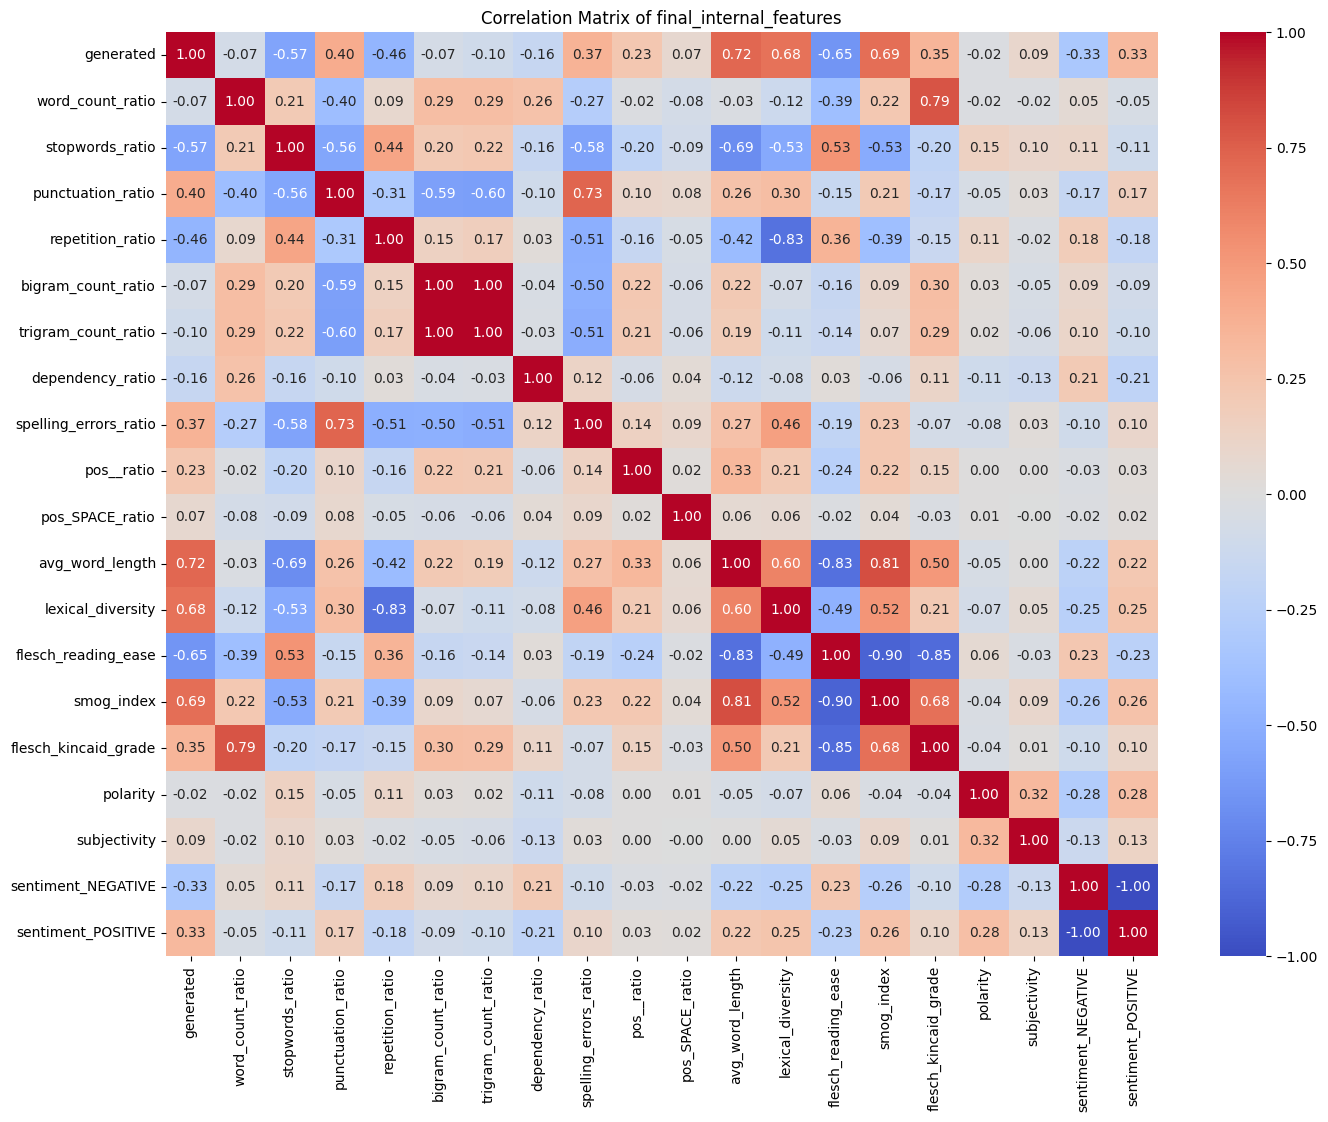

In [40]:
correlation_matrix = final_internal_features.corr()

# Plot the correlation matrix
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of final_internal_features")
plt.show()

In [42]:
# Display the correlation of all features with 'generated'
correlation_internal= correlation_matrix['generated'].sort_values(ascending=False)
print("\nCorrelation with 'generated' column:\n", correlation_internal)


Correlation with 'generated' column:
 generated                1.000000
avg_word_length          0.722652
smog_index               0.690975
lexical_diversity        0.678662
punctuation_ratio        0.398543
spelling_errors_ratio    0.365555
flesch_kincaid_grade     0.348851
sentiment_POSITIVE       0.325718
pos__ratio               0.234181
subjectivity             0.092225
pos_SPACE_ratio          0.071966
polarity                -0.019944
bigram_count_ratio      -0.068756
word_count_ratio        -0.074613
trigram_count_ratio     -0.097747
dependency_ratio        -0.159858
sentiment_NEGATIVE      -0.325718
repetition_ratio        -0.461239
stopwords_ratio         -0.566064
flesch_reading_ease     -0.653542
Name: generated, dtype: float64


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Prepare your dataset with selected features
correlation_threshold = 0.3
correlation_matrix = final_internal_features.corr()
strong_correlations = correlation_matrix['generated'].abs() > correlation_threshold
selected_features = strong_correlations[strong_correlations].index.tolist()
selected_features.remove('generated')
X = final_internal_features[selected_features]
y = final_internal_features['generated']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# Function to train and evaluate each model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)
    print("="*60)

# Iterate over each model
for name, model in models.items():
    print(f"Evaluating {name}...")
    evaluate_model(model, X_train, X_test, y_train, y_test)

Evaluating Logistic Regression...
Model: LogisticRegression
Accuracy: 0.9250535331905781
Confusion Matrix:
 [[414  39]
 [ 31 450]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.91      0.92       453
         1.0       0.92      0.94      0.93       481

    accuracy                           0.93       934
   macro avg       0.93      0.92      0.92       934
weighted avg       0.93      0.93      0.93       934

Evaluating SVM...
Model: SVC
Accuracy: 0.9047109207708779
Confusion Matrix:
 [[417  36]
 [ 53 428]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.92      0.90       453
         1.0       0.92      0.89      0.91       481

    accuracy                           0.90       934
   macro avg       0.90      0.91      0.90       934
weighted avg       0.91      0.90      0.90       934

Evaluating Random Forest...
Model: RandomForestClassifier
Accuracy:

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Model: AdaBoostClassifier
Accuracy: 0.917558886509636
Confusion Matrix:
 [[412  41]
 [ 36 445]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.91      0.91       453
         1.0       0.92      0.93      0.92       481

    accuracy                           0.92       934
   macro avg       0.92      0.92      0.92       934
weighted avg       0.92      0.92      0.92       934



[LightGBM] [Info] Number of positive: 1830, number of negative: 1906
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2072
[LightGBM] [Info] Number of data points in the train set: 3736, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489829 -> initscore=-0.040691
[LightGBM] [Info] Start training from score -0.040691


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


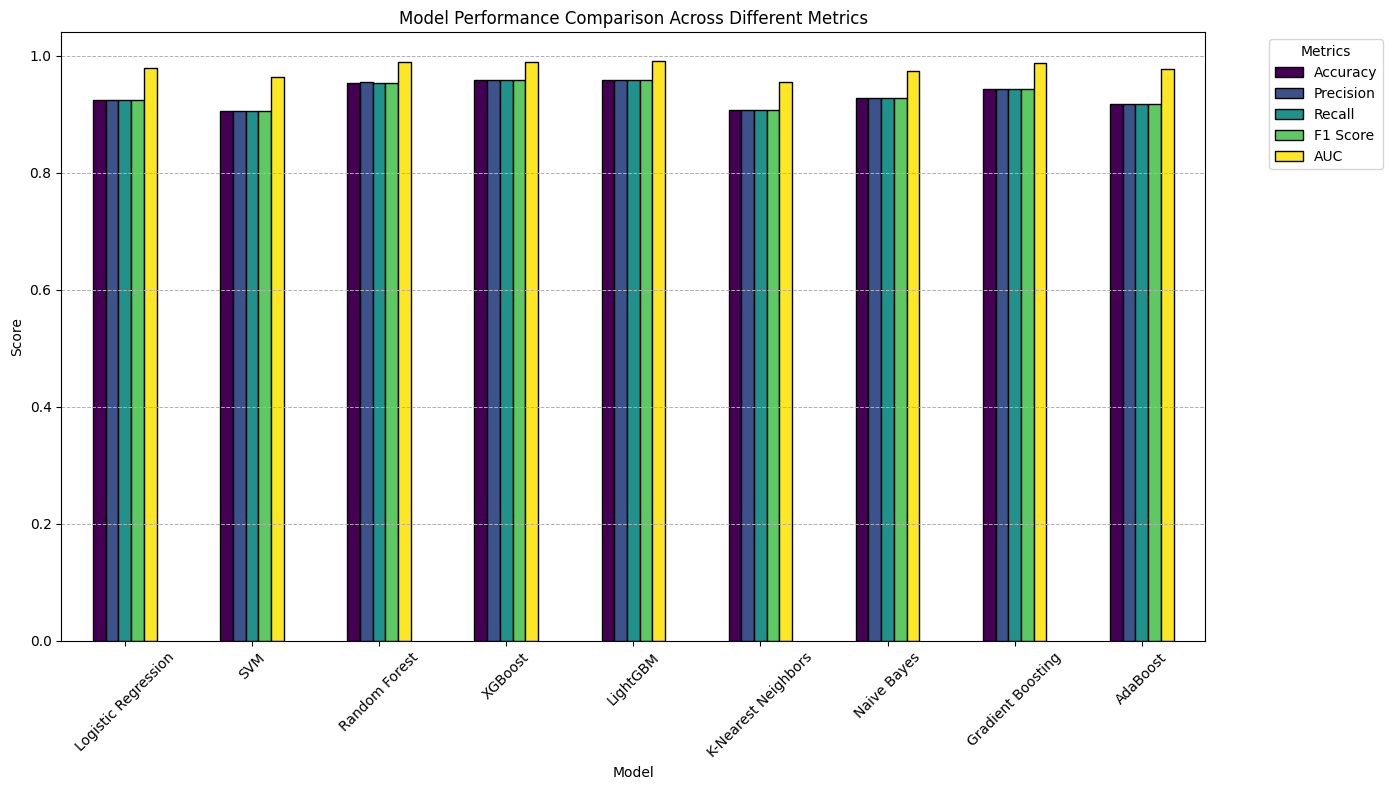

In [57]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Dictionary to store the metrics for each model
metrics_summary = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC': []
}

# Calculate metrics for each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Append metrics to summary
    metrics_summary['Model'].append(name)
    metrics_summary['Accuracy'].append(accuracy)
    metrics_summary['Precision'].append(precision)
    metrics_summary['Recall'].append(recall)
    metrics_summary['F1 Score'].append(f1)
    metrics_summary['AUC'].append(auc)

# Convert the summary into a DataFrame for plotting
metrics_df = pd.DataFrame(metrics_summary)
metrics_df.set_index('Model', inplace=True)

# Plotting the metrics in a grouped bar chart
metrics_df.plot(kind="bar", figsize=(14, 8), colormap='viridis', edgecolor="black", linewidth=1)

# Adding plot details
plt.title("Model Performance Comparison Across Different Metrics")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis="y", linestyle="--", linewidth=0.7)
plt.show()